In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [107]:
# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어있음. 이를 DataFrame으로 로드
feature_name_df = pd.read_csv('./human_activity/features.txt', sep ='\s+', header= None, names=['column_index','column_name'])
feature_name_df

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y
...,...,...
556,557,"angle(tBodyGyroMean,gravityMean)"
557,558,"angle(tBodyGyroJerkMean,gravityMean)"
558,559,"angle(X,gravityMean)"
559,560,"angle(Y,gravityMean)"


In [108]:
# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 개만 추출
feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [109]:
# 중복된 피처들 제거
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index']> 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [110]:
def get_new_feature_name_df(old_feature_name_df):
    #column_name으로 중복된 컬럼명에 대해서는 중복 차수 부여, col1, col1과 같이 2개의 중복 컬럼이 있을 경우 1, 2 
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    # feature_dup_df의 index인 column_name을 reset_index()를 이용하여 컬럼으로 변환. 
    feature_dup_df = feature_dup_df.reset_index()
    # 인자로 받은 features_txt의 컬럼명 DataFrame과 feature_dup_df를 조인. 
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    # 새로운 컬럼명은 앞에 중복 차수를 접미어로 결합. 
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df


In [141]:
def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [142]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [143]:

print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#예제 반복 시마다 동일한 예측결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


### GridSearchCV를 이용하여 파라미터를 수정하여 성능을 더 향상

In [145]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6,8,10,12,16,20,24]
}
grid_cv = GridSearchCV(dt_clf, param_grid= params, scoring='accuracy',cv=5, verbose =1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))


print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [21]:
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [22]:
max_depth = [6,8,10,12,16,20,24]
# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depth:
    dt_clf = DecisionTreeClassifier(max_depth = depth, random_state=156)
    
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth,accuracy))

    

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


In [23]:
params = {
    'max_depth' : [8,12,16,20],
    'min_samples_split' : [16,24],
}

grid_cv = GridSearchCV(dt_clf, param_grid= params, scoring='accuracy',cv=5, verbose =1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))


print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [24]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정트리 예측 정확도:{0:.4f}'.format(accuracy))

결정트리 예측 정확도:0.8717


#### 막대그래프


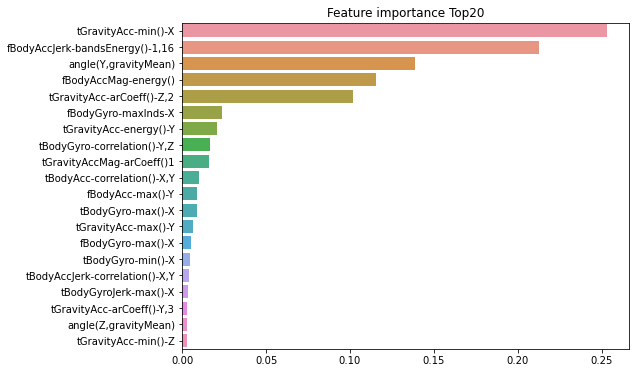

In [25]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# TOP 중요도로 정렬을 쉽게 하고, 시본을 이용하여 막대그래프로 쉽게 표현하기 위해 series 변환
ftr_importances = pd.Series(ftr_importances_values, index =X_train.columns)
# 중요도 값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending= False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importance Top20')
sns.barplot(x= ftr_top20, y= ftr_top20.index)
plt.show()

### 앙상블 학습

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [27]:
feature_name_df = pd.read_csv('./human_activity/features.txt', sep ='\s+', header= None, names=['column_index','column_name'])
feature_name_df

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y
...,...,...
556,557,"angle(tBodyGyroMean,gravityMean)"
557,558,"angle(tBodyGyroJerkMean,gravityMean)"
558,559,"angle(X,gravityMean)"
559,560,"angle(Y,gravityMean)"


In [118]:
lrc = LogisticRegression(max_iter= 1000)
svc = SVC(probability= True)
knn = KNeighborsClassifier()

## 앙상블 학습

###  Hard Voting

In [29]:
from sklearn.ensemble import VotingClassifier

voc = VotingClassifier(
    estimators=[('LRC', lrc), ('SVC', svc),('KNN',knn)],voting='hard'
)

In [30]:
voc.fit(X_train, y_train)
voc.score(X_train, y_train)

0.9899347116430903

In [31]:
# 개별 분류기의 성능


In [32]:
lrc.fit(X_train, y_train)
svc.fit(X_train, y_train)
knn.fit(X_train, y_train)
lrc.score(X_test, y_test), svc.score(X_test, y_test), knn.score(X_test, y_test)

(0.9613165931455717, 0.9504580929759077, 0.9015948422124194)

### 소프트 보팅

In [33]:
print(dir(lrc)) 

['C', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_n_features', '_estimator_type', '_get_param_names', '_get_tags', '_more_tags', '_predict_proba_lr', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', 'class_weight', 'classes_', 'coef_', 'decision_function', 'densify', 'dual', 'fit', 'fit_intercept', 'get_params', 'intercept_', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_features_in_', 'n_iter_', 'n_jobs', 'penalty', 'predict', 'predict_log_proba', 'predict_proba', 'random_state', 'score', 'set_params', 'solver', 'sparsify', 'tol', 'verbose', 'warm_start']


In [34]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [35]:
svc2 = SVC(probability=True)
svc2.fit(X_train, y_train)
svc2.predict_proba(X_test[:5])

array([[2.14954909e-04, 4.22578228e-04, 2.55275494e-04, 1.28300884e-03,
        9.97219396e-01, 6.04786659e-04],
       [1.64097173e-04, 1.57161770e-04, 1.24213516e-04, 1.47418031e-02,
        9.84178900e-01, 6.33824017e-04],
       [1.34440002e-04, 6.39183729e-05, 1.42859631e-04, 4.57098628e-03,
        9.94731938e-01, 3.55857421e-04],
       [1.17821711e-04, 8.53705899e-05, 1.48666849e-04, 2.42282902e-03,
        9.96817093e-01, 4.08218923e-04],
       [5.39158046e-05, 4.60388487e-05, 7.97831521e-05, 1.10955208e-03,
        9.98427482e-01, 2.83228183e-04]])

In [36]:
knn.predict_proba(X_test[:5])

array([[0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0.2, 0.8, 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ]])

In [38]:
voc2 = VotingClassifier(
    estimators=[('LRC', lrc),('SVC',svc),('KNN',knn)], voting='soft'
)

In [39]:
voc2.fit(X_train, y_train)
voc2.score(X_test, y_test)

0.9606379368849678

In [146]:
classifiers = [lrc,svc,knn]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도:{1:.4f}'.format(class_name, accuracy_score(y_test,pred)))

LogisticRegression 정확도:0.9613
SVC 정확도:0.9505
KNeighborsClassifier 정확도:0.9016


### Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings 
warnings.filterwarnings('ignore')



In [119]:
rf_clf = RandomForestClassifier(random_state=2022)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'랜덤포레스트 정확도 : {accuracy:.4f}')

랜덤포레스트 정확도 : 0.0244


### XGBoost

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from xgboost import XGBClassifier

In [122]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, ', end='')
    print(f'F1: {f1:.4f}, AUC: {roc_auc:.4f}')

In [123]:
# XGBoost 분류기로 학습, 예측, 평가 수행
xgb = XGBClassifier()
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [133]:
y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])

In [135]:
y_train = y_train -1
y_train


,action
0,3
1,3
2,3
3,3
4,3
...,...
7347,0
7348,0
7349,0
7350,0


In [137]:
xgb = XGBClassifier(use_label_encoder=False, 
                    )
xgb.fit(X_train, y_train)


ValueError: The label must consist of integer labels of form 0, 1, 2, ..., [num_class - 1].

In [138]:
from sklearn.metrics import accuracy_score
pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'XGboost 정확도 : {accuracy:.4f}')

NotFittedError: need to call fit or load_model beforehand

In [ ]:
### 정리
1. 결정트리 예측 정확도: 0.8548

2. GridSearchCV 최고 평균 정확도 수치: 0.8549

3. hard Voting:
    LogisticRegression 정확도:0.9613
    SVC 정확도:0.9505
    KNeighborsClassifier 정확도:0.9016

4. RandomForest 정확도 : 0.0244
    
